# Trapped Ion Calculator (TrICal)

This is a package for simulating a chain of trapped ions. The aim of this package is to remove the need for rewriting the same code to calculate equilibrium spacing, normal modes, and $J_{ij}$ every time a trap is being designed.

## Class Structure

![class structure](class_structure_trical_mechanical.png)

The basic form of the class structure is shown in the diagram. Typically in an ion trap there are three major terms in the potential; the DC part, the RF part and the coulomb part. In this code the user will input the DC and RF parts into the potential class. For the RF potential the pondermotive approximation will have to be taken before inputing the potential into the code.

## Usage

The typical usage for this code will be to find the normal modes and frequencies for a given trap and for a given set of voltage applied to the trap electrodes. The potential around the centre of the trap is should be calculated via an appropriate method. The results of that calculation can then be input into the Potential class via three methods. The potential class is then used to calculate equilibrium spacing and normal modes. These are in turn fed into the SimulatedSpinLattice class to get out $J_{ij}$ coefficients.


In [1]:
import matplotlib
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
from matplotlib import cm

import oqd_trical
import oqd_trical.misc.constants as cst
from oqd_trical.misc.polynomial import multivariate_polyfit

In [2]:
matplotlib.rcParams["figure.figsize"] = (12, 8)
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.size"] = 20

sym.init_printing()

# TrICal Classes


## Potential Class

The potential class represents a potential applied to the trapped ion system. <br />
Requirements of the potential class are functions corresponding to:

- Function for the potential, phi $(U)$
- Function for creating first derivatives of the potential, dphi $\left(\frac{\partial U}{\partial a_i}\right)$
- Function for creating second derivatives of the potential, d2phi $\left(\frac{\partial^2 U}{\partial a_i \partial b_j}\right)$ <br />

where $a,b \in [x,y,z]$ and $1 \leq i,j \leq N$ <br />
Optional parameters of Potential class are:

- Number of ions, N
- Dimension of the system, dim


In [3]:
N = 3  # Number of ions
dim = 3  # Dimension of system


# Function representing potential
def phi(x):
    x = np.array(x)
    return (x**2).sum()


# Function creating first derivatives of the potential
def dphi(var):
    a = {"x": 0, "y": 1, "z": 2}[var[0]]  # Direction index
    i = int(var[1:] if isinstance(var, str) else var[1:][0]) - 1  # Ion index

    # First derivative of the potential wrt to the variable a_i
    def dphi_dai(x):
        return 2 * x[i, a]

    return dphi_dai


# Function creating second derivatives of the potential
def d2phi(var1, var2):
    a = {"x": 0, "y": 1, "z": 2}[var1[0]]  # Direction index 1
    b = {"x": 0, "y": 1, "z": 2}[var2[0]]  # Direction index 2
    i = int(var1[1:] if isinstance(var1, str) else var1[1:][0]) - 1  # Ion index 1
    j = int(var2[1:] if isinstance(var2, str) else var2[1:][0]) - 1  # Ion index 2

    # Second derivative of the potential wrt to the variables a_i and b_j
    def d2phi_daidbj(x):
        if a == b and i == j:
            return 2
        else:
            return 0

    return d2phi_daidbj


# Define an instance of the Potential class using the above functions for potential, first derivatives and second
# derivatives
p = oqd_trical.mechanical.Potential(phi, dphi, d2phi, N=N, dim=dim)

# Function representing gradient of the potential
p_grad = p.gradient()  # Method creating function for gradient of the potential

# Function representing Hessian of the potential
p_hess = p.hessian()  # Method creating function for Hessian of the potential

# Test position of ions
x = np.arange(N * dim).reshape(N, dim)

print("Position of ions:")
print(x)
print("Potential:")
print(p(x))
print("Gradient of the potential:")
print(p_grad(x))
print("Hessian of the potential:")
print(p_hess(x))

Position of ions:
[[0 1 2]
 [3 4 5]
 [6 7 8]]
Potential:
204
Gradient of the potential:
[12.  0.  6. 14.  2.  8. 16.  4. 10.]
Hessian of the potential:
[[2. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 2.]]


### CoulombPotential Subclass

The CoulombPotential subclass represents the coulomb interaction between the ions in the trapped ion syste. Corresponds to the following potential,

$$
U(\{\vec{x}_i\}) = \sum_{i \neq j} \frac{q^2}{4 \pi \epsilon_0} \frac{1}{||\vec{x}_i - \vec{x}_j||_2}
$$

CoulombPotential only requires:

- Number of ions, N
- Dimension of the system, dim (default = 3)


In [4]:
N = 3  # Number of ions
dim = 3  # Dimension of system

# Define an instance of the CoulombPotential class for N ions in a dim-dimensional system
cp = oqd_trical.mechanical.CoulombPotential(N, dim=dim)

### GaussianOpticalPotential Subclass

The GaussianOpticalPotential subclass represents the potential caused by stark shift from a gaussian beam.

$$
U(\{\vec{x}_i\}) = \frac{\hbar \Omega^2(\{\vec{x}_i\})}{4 \Delta} = \frac{\hbar \bar{\Omega}^2 I(\{\vec{x}_i\})}{4 \Delta} = \frac{\hbar \bar{\Omega}^2}{4 \Delta} \sum_{i} \tilde{I}(\vec{x}_i) \\
\tilde{I}(x,y,z) = I_0 \left(\frac{w_0}{w(x-x^*)}\right)^2 \mathrm{exp} \left({\frac{-2[(y-y^*)^2+(z-z^*)^2]}{w^2(x-x^*)}}\right) \\
w(x) = w_0 \sqrt{1+\left(\frac{x}{x_R}\right)^2}, \quad x_R = \frac{\pi w_0^2 n}{\lambda}, \quad I_0 = \frac{2P}{\pi w_0^2}\\
$$

Where $\vec{x}^*$ is the focal point, $w_0$ is the beam waist, $n$ is the refractive index, $\lambda$ is the wavelength of laser, $P$ is the laser power, $\Delta$ is the detuning from transition, and $\bar{\Omega}$ is the Rabi frequency per root intensity. <br />

GaussianOpticalPotential requires the above list of arguments and is forced to be 3-dimensional.


In [5]:
N = 3  # Number of ions
mass = 171 * cst.m_u  # Mass of an ion

# Parameters of the gaussian beam (in SI units)
focal_point = np.zeros(3)  # Center of system
beam_waist = 1e-6
refractive_index = 1.0
wavelength = 375e-9
power = 1e0
Omega_bar = 2.23e6
transition_wavelength = 369.52e-9

# Define an instance of the GaussianOpticalPotential class
gop = oqd_trical.mechanical.GaussianOpticalPotential(
    focal_point,
    power,
    wavelength,
    beam_waist,
    mass=mass,
    Omega_bar=Omega_bar,
    transition_wavelength=transition_wavelength,
    refractive_index=refractive_index,
)

# Assign a number of ions to the GaussianOpticalPotential class
gop.update_params(N=N)  # Without N cannot create gradient or Hessian

### PolynomialPotential Subclass

The PolynomialPotential subclass corresponds with a multivariate polynomial potential:

$$
U(\{\vec{x}_i\}) = \sum_{i} \tilde{U}(\vec{x}_i) \\
\tilde{U}(x,y,z) = \sum_{ijk} \alpha_{ijk}  x^iy^jz^k
$$


In [6]:
N = 3  # Number of ions
mass = 171 * cst.m_u  # Mass of an ion

# Trapping strength (in rad/s)
omega_x = 2 * np.pi * 0.4e6  # Direction x
omega_y = 2 * np.pi * 0.36e6  # Direction y
omega_z = 2 * np.pi * 0.08e6  # Direction z
omega = np.array([omega_x, omega_y, omega_z])

# Coefficients of the multivariate polynomial consistent with the trapping strength above for a harmonic potential
alpha = np.zeros((3, 3, 3))
alpha[2, 0, 0] = mass * (omega_x) ** 2 / 2
alpha[0, 2, 0] = mass * (omega_y) ** 2 / 2
alpha[0, 0, 2] = mass * (omega_z) ** 2 / 2

[
    print(
        "Trapping strength is the {} direction (Mrad/s): {}".format(
            ["x", "y", "z"][i], omega[i] / 1e6
        )
    )
    for i in range(3)
]
print("Coefficient of the multivariate polynomial:")
print(alpha)

# Define an instance of the PolynomialPotential class
pp = oqd_trical.mechanical.PolynomialPotential(alpha, N=N)

Trapping strength is the x direction (Mrad/s): 2.5132741228718345
Trapping strength is the y direction (Mrad/s): 2.261946710584651
Trapping strength is the z direction (Mrad/s): 0.5026548245743669
Coefficient of the multivariate polynomial:
[[[0.00000000e+00 0.00000000e+00 3.58719449e-14]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [7.26406884e-13 0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

 [[8.96798622e-13 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]]]


#### Fitting to a PolynomialPotential

We can use a grid of points and the value of the potential at each point to create a PolynomialPotential by fitting it with a polynomial.


In [7]:
N = 3  # Number of ions

# Create grid of points
I_x = np.linspace(-2e-4, 2e-4, 81)
I_y = np.linspace(-2e-4, 2e-4, 81)
I_z = np.linspace(-5e-4, 5e-4, 201)
r = np.array(np.meshgrid(I_x, I_y, I_z))
r = r.reshape(3, -1).transpose()  # Last axis is axis for the direction x,y and z


# Function for the potential
def f(x, y, z):
    return np.polynomial.polynomial.polyval3d(x, y, z, alpha)


# Values of potential at grid points
U_r = f(*r.transpose())

# Parameters of fitting polynomial
l = 1e-6  # length scale  # noqa: E741
deg = (2, 2, 2)  # degree of polynomial

# Fitting polynomial using the values and grid points
alpha_fit = multivariate_polyfit(r, U_r, deg)

print("Coefficient of the multivariate polynomial fit:")
print(alpha)

# Define an instance of the PolynomialPotential class for the coeffiecients obtained from the multivariate polynomial fit
pfp = oqd_trical.mechanical.PolynomialPotential(alpha_fit, N=N)

Coefficient of the multivariate polynomial fit:
[[[0.00000000e+00 0.00000000e+00 3.58719449e-14]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [7.26406884e-13 0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

 [[8.96798622e-13 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]]]


### SymbolicPotential Subclass

The SymbolicPotential class uses a symbolic expression, defined using sympy, for the potential. This is intended to be useful when you have an analytical expression for your trapping potential. Note, all ions are assumed to have the same potential, i.e.

$$
U(\{\vec{x}_i\}) = \sum_{i} \tilde{U}(\vec{x}_i)
$$


In [8]:
N = 3  # Number of ions
dim = 3  # Dimension of system

# Symbol for the directions
x, y, z = sym.symbols("x, y ,z")

# Expression for the potential on an ion
expr = (
    mass * (omega_x) ** 2 / 2 * x**2
    + mass * (omega_y) ** 2 / 2 * y**2
    + mass * (omega_z) ** 2 / 2 * z**2
)

print("Expression for the potential on an ion:")
print(expr)

# Define an instance of the SymbolicPotential class for the expression above
sp = oqd_trical.mechanical.SymbolicPotential(expr, N=N, dim=dim)

Expression for the potential on an ion:
8.96798621816869e-13*x**2 + 7.26406883671664e-13*y**2 + 3.58719448726748e-14*z**2


#### SymbolicOpticalPotential

The SymbolicOpticalPotential is a special case of the SymbolicPotential that corresponds to an optical potential. Instead of specifying the full expression of the potential, only the expression for the intensity of the light, $\tilde{I}(\vec{x})$, the detuning, $\Delta$ and the Rabi frequency per root intensity, $\bar{\Omega}$, is needed,

$$
U(\{\vec{x}_i\}) = \frac{\hbar \Omega^2(\{\vec{x}_i\})}{4 \Delta} = \frac{\hbar \bar{\Omega}^2 I(\{\vec{x}_i\})}{4 \Delta} = \frac{\hbar \bar{\Omega}^2}{4 \Delta} \sum_{i} \tilde{I}(\vec{x}_i)
$$

Note, this potential is assumed to be 3 dimensional.


In [9]:
# Parameters for a Gaussian beam
focal_point = np.zeros(3)
beam_waist = 1e-6
refractive_index = 1.0
wavelength = 375e-9
power = 1e0
Omega_bar = 2.23e6
transition_wavelength = 369.52e-9

# Symbol for the directions
x, y, z = sym.symbols("x, y ,z")

# Defining intensity expression for the Gaussian beam with the above parameters
delta_x, delta_y, delta_z = np.array([x, y, z]) - focal_point
x_R = np.pi * beam_waist**2 * refractive_index / wavelength
w = beam_waist * sym.sqrt(1 + (delta_x / x_R) ** 2)
intensity_expr = (
    2
    * power
    / (np.pi * beam_waist**2)
    * (beam_waist / w) ** 2
    * sym.exp(-2 * (delta_y**2 + delta_z**2) / w**2)
)

# Define an instance of the SymbolicOpticalPotential class for the Gaussian beam defined above
sop = oqd_trical.mechanical.SymbolicOpticalPotential(
    intensity_expr,
    wavelength,
    Omega_bar=Omega_bar,
    transition_wavelength=transition_wavelength,
)

# Assign a number of ions to the SymbolicOpticalPotential class
sop.update_params(N=N)  # Without N cannot create gradient or Hessian

### AdvancedSymbolicPotential Subclass

The AdvancedSymbolicPotential class represents a potential that can be ion dependent symbolically, i.e.

$$
U(\{\vec{x}_i\}) = \sum_{i} \tilde{U}_i(\vec{x}_i)
$$

This means this class works for any arbitrary potential.


In [10]:
N = 3  # Number of ions
dim = 3  # Dimension of system

# Symbols for the coordinates of the different ions
x = np.array(sym.symbols(" ".join(["x{}".format(i) for i in range(N)])))
y = np.array(sym.symbols(" ".join(["y{}".format(i) for i in range(N)])))
z = np.array(sym.symbols(" ".join(["z{}".format(i) for i in range(N)])))

# Symbolic expression for the potential
expr = (
    (mass * omega_x**2 * x**2 / 2).sum()
    + (mass * omega_y**2 * y**2 / 2).sum()
    + (mass * omega_z**2 * z**2 / 2).sum()
)

# Define an instance of the AdvancedSymbolicPotential class for a harmonic potential
asp = oqd_trical.mechanical.AdvancedSymbolicPotential(N, expr, dim=dim)

### AutoDiffPotential Subclass

The AutoDiffPotential subclass uses a function representing the potential (defined using numpy subpackage of autograd package) and uses automatic differentiation to take the derivatives. This class works for any arbitrary potential


In [11]:
from autograd import numpy as agnp

N = 3  # Number of ions
dim = 3  # Dimension of system


# function for the potential defined using autograd.numpy
def expr(x):
    return agnp.sum(
        mass * (omega_x) ** 2 / 2 * x[:, 0] ** 2
        + mass * (omega_y) ** 2 / 2 * x[:, 1] ** 2
        + mass * (omega_z) ** 2 / 2 * x[:, 2] ** 2
    )


# Define an instance of the AutoDiffPotential class for a harmonic potential
adp = oqd_trical.mechanical.AutoDiffPotential(expr, N=N, dim=dim)

#### OpticalPotential Subclass

OpticalPotential is similar to SymbolicOpticalPotential, except it uses automatic differentiation instead of symbolic differentiation.

$$
U(\{\vec{x}_i\}) = \frac{\hbar \Omega^2(\{\vec{x}_i\})}{4 \Delta} = \frac{\hbar \bar{\Omega}^2 I(\{\vec{x}_i\})}{4 \Delta} = \frac{\hbar \bar{\Omega}^2}{4 \Delta} \sum_{i} \tilde{I}(\vec{x}_i)
$$


In [12]:
N = 3  # Number of ions

# Parameters for a Gaussian beam
focal_point = np.zeros(3)
beam_waist = 1e-6
refractive_index = 1.0
wavelength = 375e-9
power = 1e0
Omega_bar = 2.23e6
transition_wavelength = 369.52e-9


# Function for the intensity for the Gaussian beam with the above parameters defined using autograd.numpy
def intensity_expr(x):
    delta_x = x - focal_point
    x_R = np.pi * beam_waist**2 * refractive_index / wavelength
    w = beam_waist * agnp.sqrt(1 + (delta_x[:, 0] / x_R) ** 2)
    return (
        2
        * power
        / (np.pi * beam_waist**2)
        * (beam_waist / w) ** 2
        * agnp.exp(-2 * (delta_x[:, 1] ** 2 + delta_x[:, 2] ** 2) / w**2)
    ).sum()


# Define an instance of the OpticalPotential class for the Gaussian beam defined above
op = oqd_trical.mechanical.OpticalPotential(
    intensity_expr,
    wavelength,
    Omega_bar=Omega_bar,
    transition_wavelength=transition_wavelength,
)

# Assign a number of ions to the SymbolicOpticalPotential class
op.update_params(N=N)  # Without N cannot create gradient or Hessian

## TrappedIons Class

This class calculates the equilibrium positions, normal modes, and frequencies of a given number of ions and trapping potential. The method of inputing the potential should not have any bearing on the equilibrum position. Using the equilibrium_position funciton we can see that all three input methods give the same positions in z.

### Single Species


In [13]:
N = 3  # Number of ions
mass = 171 * cst.m_u  # Mass of an ion

# Harmonic trapped ion system
ti = oqd_trical.mechanical.TrappedIons(N, pp, m=mass)

# Calculate equilibrium position
ti.equilibrium_position()

# Calculate normal modes
ti.normal_modes()  # If equilibrium position does not exist it will run equilibrium_position method

# Calculate normal modes in principal axes if it exist
ti.principal_axes()  # If normal modes does not exist it will run normal_modes method

print("{}:{}".format("Equilibrium Position (micron)", np.round(ti.x_ep[:, 2] * 1e6, 5)))
print("{}:{}".format("Eigenfrequencies (Mrad/s)", np.round(ti.w_pa / 1e6, 5)))
print("{}:".format("principal axes Eigenvectors"))
print(np.round(ti.b_pa, 5))

Equilibrium Position (micron):[-15.89995   0.       15.89995]
Eigenfrequencies (Mrad/s):[2.51327 2.4625  2.38959 2.26195 2.20539 2.12368 1.21055 0.87062 0.50265]
principal axes Eigenvectors:
[[ 0.57735 -0.70711  0.40825  0.       0.      -0.       0.       0.
  -0.     ]
 [ 0.57735  0.      -0.8165   0.       0.       0.      -0.      -0.
  -0.     ]
 [ 0.57735  0.70711  0.40825  0.      -0.      -0.      -0.       0.
  -0.     ]
 [-0.       0.      -0.       0.57735  0.70711  0.40825  0.       0.
  -0.     ]
 [-0.       0.       0.       0.57735 -0.      -0.8165   0.      -0.
  -0.     ]
 [-0.      -0.      -0.       0.57735 -0.70711  0.40825 -0.       0.
  -0.     ]
 [ 0.       0.      -0.      -0.      -0.      -0.       0.40825  0.70711
   0.57735]
 [ 0.      -0.      -0.      -0.       0.       0.      -0.8165  -0.
   0.57735]
 [ 0.       0.       0.       0.      -0.       0.       0.40825 -0.70711
   0.57735]]


In [14]:
N = 3  # Number of ions
mass = 171 * cst.m_u  # Mass of an ion

# Harmonic trapped ion system defined using different methods
ti_pp = oqd_trical.mechanical.TrappedIons(N, pp, m=mass)  # PolynomialPotential
ti_pfp = oqd_trical.mechanical.TrappedIons(
    N, pfp, m=mass
)  # PolynomialPotential by fitting coeffiencients
ti_sp = oqd_trical.mechanical.TrappedIons(N, sp, m=mass)  # SymbolicPotential
ti_asp = oqd_trical.mechanical.TrappedIons(N, asp, m=mass)  # AdvancedSymbolicPotential
ti_adp = oqd_trical.mechanical.TrappedIons(N, adp, m=mass)  # AutoDiffPotential

print("{:=^100}".format(" PolynomialPotential "))
print("{}:".format("Execution time for principal axes method"))
%timeit ti_pp.principal_axes()
print(
    "{}:{}".format("Equilibrium Position (micron)", np.round(ti_pp.x_ep[:, 2] * 1e6, 5))
)
print("{}:{}".format("Eigenfrequencies (Mrad/s)", np.round(ti_pp.w_pa / 1e6, 5)))
print("{}:".format("principal axes Eigenvectors"))
print(np.round(ti_pp.b_pa, 5))

print("{:=^100}".format(" Fitted PolynomialPotential "))
print("{}:".format("Execution time for principal axes method"))
%timeit ti_pfp.principal_axes()
print(
    "{}:{}".format(
        "Equilibrium Position (micron)", np.round(ti_pfp.x_ep[:, 2] * 1e6, 5)
    )
)
print("{}:{}".format("Eigenfrequencies (Mrad/s)", np.round(ti_pfp.w_pa / 1e6, 5)))
print("{}:".format("principal axes Eigenvectors"))
print(np.round(ti_pfp.b_pa, 5))

print("{:=^100}".format(" SymbolicPotential "))
print("{}:".format("Execution time for principal axes method"))
%timeit ti_sp.principal_axes()
print(
    "{}:{}".format("Equilibrium Position (micron)", np.round(ti_sp.x_ep[:, 2] * 1e6, 5))
)
print("{}:{}".format("Eigenfrequencies (Mrad/s)", np.round(ti_sp.w_pa / 1e6, 5)))
print("{}:".format("principal axes Eigenvectors"))
print(np.round(ti_sp.b_pa, 5))

print("{:=^100}".format(" AdvancedSymbolicPotential "))
print("{}:".format("Execution time for principal axes method"))
%timeit ti_asp.principal_axes()
print(
    "{}:{}".format(
        "Equilibrium Position (micron)", np.round(ti_asp.x_ep[:, 2] * 1e6, 5)
    )
)
print("{}:{}".format("Eigenfrequencies (Mrad/s)", np.round(ti_asp.w_pa / 1e6, 5)))
print("{}:".format("principal axes Eigenvectors"))
print(np.round(ti_asp.b_pa, 5))

print("{:=^100}".format(" AutoDiffPotential "))
print("{}:".format("Execution time for principal axes method"))
%timeit ti_adp.principal_axes()
print(
    "{}:{}".format(
        "Equilibrium Position (micron)", np.round(ti_adp.x_ep[:, 2] * 1e6, 5)
    )
)
print("{}:{}".format("Eigenfrequencies (Mrad/s)", np.round(ti_adp.w_pa / 1e6, 5)))
print("{}:".format("principal axes Eigenvectors"))
print(np.round(ti_adp.b_pa, 5))

======================================= PolynomialPotential ========================================
Execution time for principal axes method:


3.84 ms ± 13.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Equilibrium Position (micron):[-15.89995   0.       15.89995]
Eigenfrequencies (Mrad/s):[2.51327 2.4625  2.38959 2.26195 2.20539 2.12368 1.21055 0.87062 0.50265]
principal axes Eigenvectors:
[[ 0.57735 -0.70711  0.40825  0.       0.      -0.       0.       0.
  -0.     ]
 [ 0.57735  0.      -0.8165   0.       0.       0.      -0.      -0.
  -0.     ]
 [ 0.57735  0.70711  0.40825  0.      -0.      -0.      -0.       0.
  -0.     ]
 [-0.       0.      -0.       0.57735  0.70711  0.40825  0.       0.
  -0.     ]
 [-0.       0.       0.       0.57735 -0.      -0.8165   0.      -0.
  -0.     ]
 [-0.      -0.      -0.       0.57735 -0.70711  0.40825 -0.       0.
  -0.     ]
 [ 0.       0.      -0.      -0.      -0.      -0.       0.40825  0.70711
   0.57735]
 [ 0.      -0.      -0.      -0.       0.       0.      -0.8165  -0.
   0.57735]
 [ 0.       0.       0.       0.      -0.       0.       0.40825 -0.70711
   0.57735

3.78 ms ± 34 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Equilibrium Position (micron):[-15.89995  -0.       15.89995]
Eigenfrequencies (Mrad/s):[2.51327 2.4625  2.38959 2.26195 2.20539 2.12368 1.21055 0.87062 0.50265]
principal axes Eigenvectors:
[[ 0.57735 -0.70711  0.40825 -0.      -0.      -0.      -0.      -0.
  -0.     ]
 [ 0.57735  0.      -0.8165   0.       0.       0.      -0.       0.
  -0.     ]
 [ 0.57735  0.70711  0.40825  0.      -0.       0.       0.       0.
  -0.     ]
 [ 0.      -0.       0.       0.57735  0.70711  0.40825  0.       0.
   0.     ]
 [ 0.      -0.       0.       0.57735 -0.      -0.8165   0.      -0.
   0.     ]
 [-0.      -0.      -0.       0.57735 -0.70711  0.40825 -0.       0.
  -0.     ]
 [ 0.      -0.       0.      -0.      -0.      -0.       0.40825  0.70711
   0.57735]
 [ 0.       0.      -0.      -0.       0.       0.      -0.8165  -0.
   0.57735]
 [ 0.       0.      -0.      -0.      -0.       0.       0.40825 -0.70711
   0.57735]]

11.2 ms ± 250 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Equilibrium Position (micron):[-15.89995   0.       15.89995]
Eigenfrequencies (Mrad/s):[2.51327 2.4625  2.38959 2.26195 2.20539 2.12368 1.21055 0.87062 0.50265]
principal axes Eigenvectors:
[[ 0.57735 -0.70711  0.40825 -0.      -0.       0.       0.       0.
  -0.     ]
 [ 0.57735  0.      -0.8165  -0.       0.      -0.      -0.       0.
  -0.     ]
 [ 0.57735  0.70711  0.40825 -0.      -0.      -0.      -0.      -0.
  -0.     ]
 [ 0.      -0.      -0.       0.57735 -0.70711  0.40825 -0.       0.
  -0.     ]
 [ 0.      -0.      -0.       0.57735  0.      -0.8165   0.      -0.
  -0.     ]
 [ 0.       0.       0.       0.57735  0.70711  0.40825  0.       0.
  -0.     ]
 [ 0.      -0.      -0.      -0.      -0.       0.       0.40825 -0.70711
   0.57735]
 [ 0.      -0.      -0.       0.       0.       0.      -0.8165   0.
   0.57735]
 [ 0.       0.       0.       0.      -0.      -0.       0.40825  0.70711
   0.57735]

85.6 ms ± 2.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Equilibrium Position (micron):[-15.89995   0.       15.89995]
Eigenfrequencies (Mrad/s):[2.51327 2.4625  2.38959 2.26195 2.20539 2.12368 1.21055 0.87062 0.50265]
principal axes Eigenvectors:
[[ 0.57735 -0.70711  0.40825  0.       0.       0.       0.      -0.
  -0.     ]
 [ 0.57735  0.      -0.8165  -0.      -0.      -0.       0.      -0.
  -0.     ]
 [ 0.57735  0.70711  0.40825  0.      -0.      -0.      -0.       0.
  -0.     ]
 [ 0.      -0.      -0.       0.57735  0.70711  0.40825  0.       0.
   0.     ]
 [-0.      -0.      -0.       0.57735 -0.      -0.8165  -0.       0.
   0.     ]
 [ 0.      -0.      -0.       0.57735 -0.70711  0.40825  0.      -0.
   0.     ]
 [ 0.      -0.      -0.       0.       0.      -0.       0.40825  0.70711
   0.57735]
 [ 0.      -0.       0.       0.      -0.      -0.      -0.8165  -0.
   0.57735]
 [ 0.       0.       0.      -0.      -0.       0.       0.40825 -0.70711
   0.57735]

2.69 ms ± 16.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Equilibrium Position (micron):[-15.89995   0.       15.89995]
Eigenfrequencies (Mrad/s):[2.51327 2.4625  2.38959 2.26195 2.20539 2.12368 1.21055 0.87062 0.50265]
principal axes Eigenvectors:
[[ 0.57735 -0.70711  0.40825  0.      -0.       0.       0.       0.
  -0.     ]
 [ 0.57735  0.      -0.8165  -0.       0.      -0.      -0.       0.
  -0.     ]
 [ 0.57735  0.70711  0.40825  0.       0.       0.      -0.      -0.
  -0.     ]
 [-0.      -0.      -0.       0.57735 -0.70711  0.40825 -0.       0.
  -0.     ]
 [-0.      -0.      -0.       0.57735  0.      -0.8165   0.      -0.
   0.     ]
 [-0.      -0.      -0.       0.57735  0.70711  0.40825 -0.      -0.
   0.     ]
 [ 0.      -0.      -0.      -0.      -0.       0.       0.40825 -0.70711
   0.57735]
 [ 0.      -0.      -0.      -0.      -0.       0.      -0.8165   0.
   0.57735]
 [ 0.       0.       0.       0.      -0.      -0.       0.40825  0.70711
   0.57735

In [15]:
N = 3  # Number of ions
dim = 3  # Dimension of system
mass = 171 * cst.m_u  # Mass of an ion

# Harmonic trapped ion system with optical tweezers on the center ion defined using different methods
ti_gop = oqd_trical.mechanical.TrappedIons(
    N, adp, gop, m=mass
)  # GaussianOpticalPotential
ti_sop = oqd_trical.mechanical.TrappedIons(
    N, adp, sop, m=mass
)  # SymbolicOpticalPotential
ti_op = oqd_trical.mechanical.TrappedIons(N, adp, op, m=mass)  # OpticalPotential

print("{:=^100}".format(" GaussianOpticalPotential "))
print("{}:".format("Execution time for principal axes method"))
%timeit ti_gop.principal_axes()
print(
    "{}:{}".format(
        "Equilibrium Position (micron)", np.round(ti_gop.x_ep[:, 2] * 1e6, 5)
    )
)
print("{}:{}".format("Eigenfrequencies (Mrad/s)", np.round(ti_gop.w_pa / 1e6, 5)))
print("{}:".format("principal axes Eigenvectors"))
print(np.round(ti_gop.b_pa, 5))

print("{:=^100}".format(" SymbolicOpticalPotential "))
print("{}:".format("Execution time for principal axes method"))
%timeit ti_sop.principal_axes()
print(
    "{}:{}".format(
        "Equilibrium Position (micron)", np.round(ti_sop.x_ep[:, 2] * 1e6, 5)
    )
)
print("{}:{}".format("Eigenfrequencies (Mrad/s)", np.round(ti_sop.w_pa / 1e6, 5)))
print("{}:".format("principal axes Eigenvectors"))
print(np.round(ti_sop.b_pa, 5))

print("{:=^100}".format(" OpticalPotential "))
print("{}:".format("Execution time for principal axes method"))
%timeit ti_op.principal_axes()
print(
    "{}:{}".format("Equilibrium Position (micron)", np.round(ti_op.x_ep[:, 2] * 1e6, 5))
)
print("{}:{}".format("Eigenfrequencies (Mrad/s)", np.round(ti_op.w_pa / 1e6, 5)))
print("{}:".format("principal axes Eigenvectors"))
print(np.round(ti_op.b_pa, 5))

===================================== GaussianOpticalPotential =====================================
Execution time for principal axes method:


3.19 ms ± 39.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Equilibrium Position (micron):[-15.89995   0.       15.89995]
Eigenfrequencies (Mrad/s):[2.51327 2.4625  2.38959 4.52781 2.21563 2.20539 4.10671 0.87062 0.79797]
principal axes Eigenvectors:
[[ 0.57735 -0.70711  0.40825 -0.      -0.      -0.       0.      -0.
  -0.     ]
 [ 0.57735  0.      -0.8165  -0.       0.      -0.       0.       0.
   0.     ]
 [ 0.57735  0.70711  0.40825 -0.      -0.       0.      -0.       0.
  -0.     ]
 [ 0.       0.       0.       0.01297  0.70699  0.70711 -0.      -0.
  -0.     ]
 [ 0.       0.       0.       0.99983 -0.01834  0.       0.       0.
   0.     ]
 [ 0.       0.       0.       0.01297  0.70699 -0.70711 -0.       0.
  -0.     ]
 [ 0.      -0.       0.      -0.       0.       0.       0.02493  0.70711
   0.70667]
 [ 0.      -0.       0.      -0.      -0.       0.      -0.99938 -0.
   0.03525]
 [ 0.       0.       0.       0.       0.      -0.       0.02493 -0.70711
   0.70667

231 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Equilibrium Position (micron):[-15.89995  -0.       15.89995]
Eigenfrequencies (Mrad/s):[2.52169 2.4625  2.40421 4.52781 2.21563 2.20539 4.10671 0.87062 0.79797]
principal axes Eigenvectors:
[[ 0.53735 -0.70711  0.45963  0.       0.      -0.       0.      -0.
  -0.     ]
 [ 0.65001  0.      -0.75993  0.      -0.       0.       0.       0.
   0.     ]
 [ 0.53735  0.70711  0.45963  0.       0.      -0.      -0.       0.
  -0.     ]
 [-0.      -0.      -0.       0.01297  0.70699 -0.70711  0.       0.
   0.     ]
 [-0.      -0.      -0.       0.99983 -0.01834 -0.       0.      -0.
   0.     ]
 [-0.      -0.      -0.       0.01297  0.70699  0.70711  0.      -0.
   0.     ]
 [ 0.      -0.       0.      -0.      -0.       0.       0.02493  0.70711
   0.70667]
 [ 0.      -0.       0.      -0.      -0.       0.      -0.99938 -0.
   0.03525]
 [ 0.       0.       0.       0.      -0.      -0.       0.02493 -0.70711
   0.70667]]
=

6.69 ms ± 52.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Equilibrium Position (micron):[-15.89995   0.       15.89995]
Eigenfrequencies (Mrad/s):[2.52169 2.4625  2.40421 4.52781 2.21563 2.20539 4.10671 0.87062 0.79797]
principal axes Eigenvectors:
[[ 0.53735 -0.70711  0.45963  0.       0.       0.       0.      -0.
  -0.     ]
 [ 0.65001  0.      -0.75993  0.      -0.      -0.       0.       0.
   0.     ]
 [ 0.53735  0.70711  0.45963  0.       0.       0.      -0.       0.
  -0.     ]
 [ 0.       0.      -0.       0.01297  0.70699  0.70711 -0.       0.
   0.     ]
 [-0.       0.      -0.       0.99983 -0.01834  0.       0.      -0.
   0.     ]
 [-0.       0.      -0.       0.01297  0.70699 -0.70711  0.       0.
  -0.     ]
 [ 0.      -0.       0.       0.      -0.      -0.       0.02493  0.70711
   0.70667]
 [ 0.      -0.       0.      -0.       0.      -0.      -0.99938 -0.
   0.03525]
 [ 0.       0.       0.      -0.       0.      -0.       0.02493 -0.70711
   0.70667

### Multiple Species


In [16]:
N = 3  # Number of ions

myb = 171 * cst.m_u  # mass of ytterbium-171
mba = 138 * cst.m_u  # mass of barium-138
ms = np.array([myb, mba, myb])  # mass array (length must be equal to number of ions)


# Expression for ion dependent multispecies harmonic potential
def expr(x):
    return (
        (myb**2 * omega_x**2 * x[:, 0] ** 2 / (2 * ms)).sum()
        + (myb**2 * omega_y**2 * x[:, 1] ** 2 / (2 * ms)).sum()
        + (myb * omega_z**2 * x[:, 2] ** 2 / 2).sum()
    )


# AutoDiffPotential for above defined ion dependent multispecies harmonic potential
adp = oqd_trical.mechanical.AutoDiffPotential(expr, N=N, dim=dim)

# Multispecies harmonic trapped ion system
ti_ms = oqd_trical.mechanical.TrappedIons(N, adp, m=ms)

# Calculates equilibrium position, normal modes and normal modes in the principal axes
ti_ms.principal_axes()

print(
    "{}:{}".format("Equilibrium Position (micron)", np.round(ti_ms.x_ep[:, 2] * 1e6, 5))
)
print("{}:{}".format("Eigenfrequencies (Mrad/s)", np.round(ti_ms.w_pa / 1e6, 5)))
print("{}:".format("principal axes Eigenvectors"))
print(np.round(ti_ms.b_pa, 5))

Equilibrium Position (micron):[-15.89995   0.       15.89995]
Eigenfrequencies (Mrad/s):[3.03814 2.46616 2.4625  2.71953 2.20759 2.20539 1.30474 0.87062 0.51914]
principal axes Eigenvectors:
[[ 0.0646   0.70258  0.70711  0.       0.       0.       0.       0.
  -0.     ]
 [ 0.99582 -0.11295  0.      -0.      -0.      -0.      -0.      -0.
  -0.     ]
 [ 0.0646   0.70258 -0.70711  0.       0.       0.      -0.       0.
  -0.     ]
 [-0.       0.      -0.       0.08092  0.70001  0.70711 -0.       0.
  -0.     ]
 [-0.      -0.       0.       0.99343 -0.14131  0.      -0.      -0.
   0.     ]
 [-0.      -0.       0.       0.08092  0.70001 -0.70711  0.      -0.
   0.     ]
 [ 0.      -0.       0.      -0.       0.       0.       0.33927  0.70711
   0.58537]
 [ 0.       0.       0.       0.      -0.       0.      -0.87738 -0.
   0.56097]
 [ 0.       0.      -0.      -0.      -0.       0.       0.33927 -0.70711
   0.58537]]


## SimulatedSpinLattice Class

This class produces the simulated coupling matrix, $J_{ij}$, when an optical field is applied on the trapped ion system. The coupling matrix, $J_{ij}$, depends on the following parameters:

- Rabi frequencies, Omega $(\Omega_{in})$
- Raman beatnote detunings, mu $(\mu_n)$
- Trapped ion normal modes, b $(b_{im})$ and omega $(\omega_{m})$
- Direction of beam, direc ("x","y" or "z")
- Wavenumber of the light, k $\left(||\vec{k}||\right)$


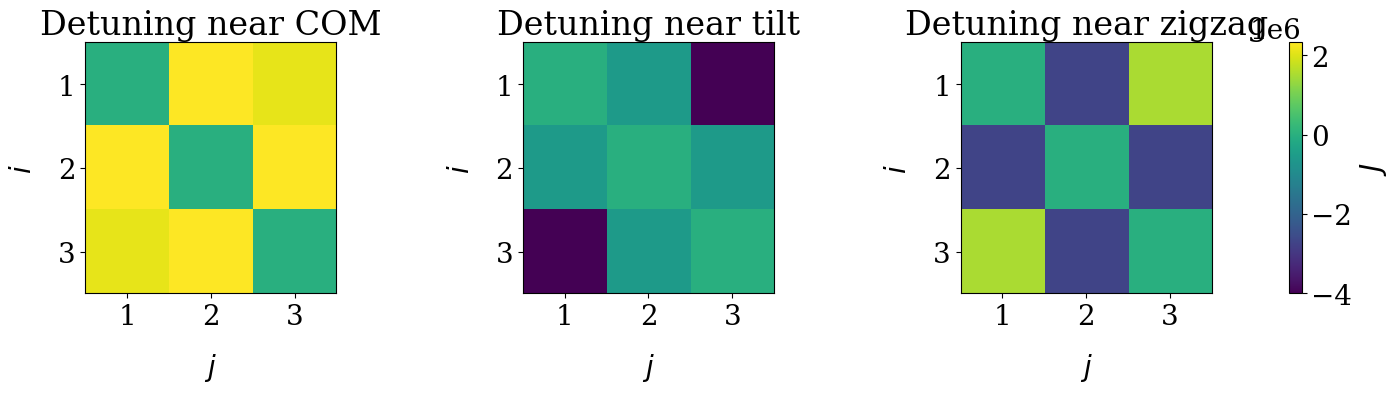

In [17]:
N = 3  # Number of ions

# Parameters for the coupling matrix
direc = "x"
wavelength = 355e-9
detuning = 2 * np.pi * 1e3
# detuning for 3 cases: near COM, near tilt and near zigzag on the right
mu = np.array([np.array([ti_adp.w_pa[:N][i] + detuning]) for i in range(N)])
omega = np.full((N, 1), 1e6)  # global beam

# Initialize SimulatedSpinLattice class, which represents the coupling matrix resulting from the above parameters
ssl = [
    oqd_trical.mechanical.SimulatedSpinLattice(
        ti, mu[i], omega, direc=direc, k=2 * np.pi / wavelength
    )
    for i in range(N)
]

# Array for the coupling matrix
J = np.array([ssl[i].J for i in range(N)])

# Plot of the coupling matrix
norm = matplotlib.colors.Normalize(J.min(), J.max())
sm = cm.ScalarMappable(norm, cmap=cm.viridis)
sm.set_array(J)

fig = plt.figure(figsize=(20, 15))
ax = [fig.add_subplot(4, 3, i + 1) for i in range(N)]
for i in range(N):
    im = ax[i].imshow(J[i], cmap=cm.viridis, norm=norm)
    ax[i].set_xticks(np.arange(N))
    ax[i].set_yticks(np.arange(N))
    ax[i].set_xticklabels(np.arange(N) + 1)
    ax[i].set_yticklabels(np.arange(N) + 1)
    ax[i].set_xlabel(r"$j$", labelpad=15)
    ax[i].set_ylabel(r"$i$", labelpad=15)
    ax[i].set_title("Detuning near {}".format(["COM", "tilt", "zigzag"][i]))
fig.colorbar(sm, ax=ax, label=r"$J$")